In [1]:
import scanpy as sc
import pandas as pd
import decoupler as dc
from anndata import AnnData

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import hdf5plugin

In [2]:
path = "../data/brca/tcga/processed/GSE161529/genes_prop_subtypes_cells_tumor.csv"
adata = pd.read_csv(path, sep=",").T

In [3]:
adata.head(5)

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RP11-744A16.4,PAUPAR,RP11-65B7.2,GIMAP1-GIMAP5,RP11-274B21.13,AF127936.7,CH17-132F21.5,RP11-439M15.1,LINC01144,RP11-418H16.1
I3 T cell,2.721351e+06,62027.733270,2.208815e+06,1.517923e+06,699867.664898,518144.315690,2.792015e+06,2.416197e+06,2.066235e+06,3.041596e+06,...,49.768821,2540.238184,1080.659600,0.0,207.436336,13223.617198,411.230758,697.402739,85004.934478,4541.753771
I1 Myeloid cell,5.504234e+05,10637.890060,4.694175e+05,3.205186e+05,147388.682519,107464.819565,6.066023e+05,5.047937e+05,4.362047e+05,6.354478e+05,...,11.177405,555.579973,228.518247,0.0,35.358202,2755.960005,85.060081,147.066368,17126.533948,926.122951
I5 Plasma cell,1.175748e+05,1948.376671,7.461686e+04,4.434732e+04,23860.652583,14943.864745,6.218674e+04,9.186923e+04,5.939042e+04,1.041412e+05,...,1.053774,104.181842,27.822154,0.0,5.205462,266.422797,14.709161,17.530893,3577.531574,191.123278


In [4]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 3 × 54645

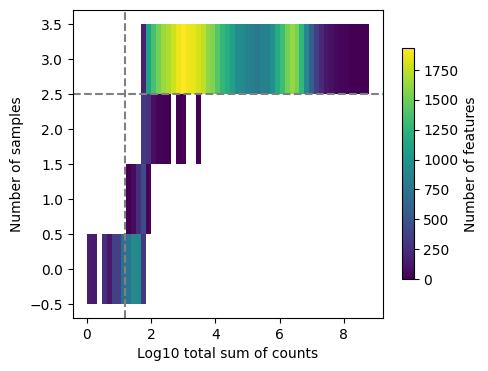

In [5]:
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)


In [6]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 3 × 46315

In [7]:
model = dc.get_progeny(organism='human', top=300)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
4195,p53,F5,2.397854,5.746843e-08
4196,p53,MKI67,-5.680340,5.758565e-08
4197,p53,THOC2,-2.108178,5.858359e-08
4198,p53,POLA1,-4.943873,5.911873e-08


In [8]:
pd.unique(model.source)

array(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK',
       'NFkB', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype=object)

In [9]:
adata.X

array([[2.7213510e+06, 6.2027734e+04, 2.2088148e+06, ..., 6.9740271e+02,
        8.5004938e+04, 4.5417539e+03],
       [5.5042338e+05, 1.0637890e+04, 4.6941750e+05, ..., 1.4706636e+02,
        1.7126533e+04, 9.2612292e+02],
       [1.1757476e+05, 1.9483767e+03, 7.4616859e+04, ..., 1.7530893e+01,
        3.5775315e+03, 1.9112328e+02]], dtype=float32)

In [10]:
# Infer pathway activities with consensus
dc.run_consensus(mat=adata, 
                 net=model,
                 use_raw=False, 
                 verbose=True)

Running consensus.
Running mlm on mat with 3 samples and 46315 targets for 14 sources.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.81it/s]


Running ulm on mat with 3 samples and 46315 targets for 14 sources.
Running wsum on mat with 3 samples and 46315 targets for 14 sources.
Infering activities on 1 batches.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


In [11]:
adata

AnnData object with n_obs × n_vars = 3 × 46315
    obsm: 'consensus_estimate', 'consensus_pvals'

In [12]:
# Extract from dictionary
acts =  adata.obsm['consensus_estimate']
pvals = adata.obsm['consensus_pvals']

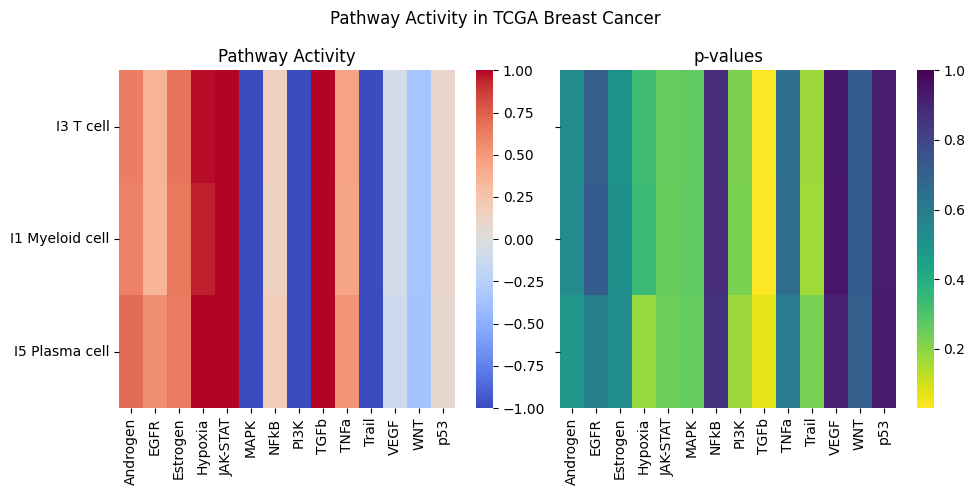

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5), tight_layout=True, sharey=True)

axes[0].set_title('Pathway Activity')
g = sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 10)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 10)
axes[1].set_title('p-values')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=1)
path = "../figures/GSE161529/Immune_subtype_cell_cancer_pathways.png"
fig.suptitle("Pathway Activity in TCGA Breast Cancer")
plt.savefig(path,format='png')
plt.show()
plt.close()

In [14]:
df = pvals[(pvals < 0.05)].copy()
df = df.dropna()
df.head()

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
